# Hyperparameter Tuning

In the previous notebook, we saw the impact of applying a `Quantile Transformer` to the dataset. What is more, the `Random Forest Regressor` was consolidated as the best performing algorithm.

The objective of this notebook it will be to apply a `GridSearchCV & RandomSearchCV` to find the best `hyperparameter tuning` configuration. To this aim, [this article from Jason Brownlee](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) was really helpful to understand the basics of both methods and select the best configuration possible.

`Hyperparameters` help on specifying the configuration of models to guide machine learning algorithms. The difference with `parameters` is that `hyperparameters` are not learned automatically, so they need to be set manually to help on the guidance of the learning process.

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Loading transformed dataset

In [2]:
root = r'../data/regression/cars_reg_trf.csv'

df = pd.read_csv(root)

df.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,gearbox_Automatic,gearbox_Direct,...,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded,price
0,-1.120443,0.285121,-2.877530,-2.143610,-0.679227,-2.897385,-2.456544,1.199172,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153,5500
1,1.303557,-1.624785,-0.685567,1.345832,1.358362,-0.272066,-0.085500,-1.377568,-5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.521013,10900
2,-0.572277,-1.297705,0.171631,0.937119,-0.833062,0.438088,-1.220053,-0.794587,5.199338,-5.199338,...,-5.199338,5.199338,-5.199338,0.698331,0.833062,0.596109,5.199338,5.199338,1.521013,36100
3,0.635580,0.540027,0.519795,0.651025,0.361889,1.079060,0.933230,-1.018128,5.199338,-5.199338,...,-5.199338,-5.199338,5.199338,0.698331,1.663600,-1.056848,-0.902609,5.199338,1.521013,28000
4,3.744070,-2.967122,0.012559,-0.174181,3.436439,0.439471,1.120443,-2.877530,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.367258,5.199338,1.521013,27990


In [3]:
# splitting features (X) & target (y)
X = df.drop('price', axis=1)
y = df['price']

print(X.shape)
print(y.shape)

if X.shape[0] == y.shape[0]:
    print("Correct shape to proceed with the fit!")
else:
    print("Please, review the shape since it is not matching fot X & y")

(55366, 29)
(55366,)
Correct shape to proceed with the fit!


## Optimizing Hyperparameters with Grid & Random Search

I found [this Towards Data Science article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) really useful to build the search methods and find the best hyperparameters. First let's define the `parameters` of each search:
* model
* space
* cv
* scoring

### Random Search method

These are the `random Forest Regressor` hyperparameters:
- `n_estimators` => number of trees in the foreset
- `max_features` => max number of features considered for splitting a node
- `max_depth` => max number of levels in each decision tree
- `min_samples_split` => min number of data points placed in a node before the node is split
- `min_samples_leaf` => min number of data points allowed in a leaf node
- `bootstrap` => method for sampling data points (with or without replacement)

Their impact to the model is better explained in [this hyperparameter tuning article](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/) dedicated to `RF`.

In [4]:
# define model
rf = RandomForestRegressor()

# define search space
param_grid = dict()
param_grid['n_estimators'] = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
param_grid['max_features'] = ['auto', 'sqrt', 'log2']
param_grid['max_depth'] = [int(x) for x in np.linspace(10, 50, num = 5)]
param_grid['max_depth'].append(None)
param_grid['min_samples_split'] = [2, 5, 10]
param_grid['min_samples_leaf'] = [1, 2, 4]
param_grid['bootstrap'] = [True, False]

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=33)

# define scoring
scoring='r2'

# define RandomSearchCV
search_rdm = RandomizedSearchCV(estimator=rf,
                                param_distributions=param_grid,
                                n_iter=100,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=True,
                                n_jobs=-1,
                                random_state=33)

In [5]:
param_grid

{'n_estimators': [10, 57, 105, 152, 200],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [6]:
# execute search
start_time = time()

result_rdm = search_rdm.fit(X, y)

rdm_time = time() - start_time

/home/dsc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [7]:
# summarize result
print('Best Score: {}'.format(result_rdm.best_score_))
print('Best Hyperparameters: {}'.format(result_rdm.best_params_))
print('Time consumed on the Seach: {}'.format(rdm_time))

Best Score: 0.8886159519268148
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Time consumed on the Seach: 14787.887508630753


### Grid Search method

Random Search method is used to reduce the range of values for each hyperparameter. Therefore, we can specify now the best configurations found to be adjusted in a Grid Search.

In [8]:
# define model
rf = RandomForestRegressor()

# define search space
param_grid = dict()
param_grid['n_estimators'] = [200, 225, 250]
param_grid['max_features'] = ['sqrt']
param_grid['max_depth'] = [80, 100, None]
param_grid['min_samples_split'] = [10, 15]
param_grid['min_samples_leaf'] = [1, 2]
param_grid['bootstrap'] = [False]

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=33)

# define scoring
scoring='r2'

# define GridSearchCV
search_grd = GridSearchCV(estimator=rf,
                          param_grid=param_grid,
                          cv=cv,
                          scoring=scoring,
                          return_train_score=True,
                          n_jobs=-1)

In [9]:
param_grid

{'n_estimators': [200, 225, 250],
 'max_features': ['sqrt'],
 'max_depth': [80, 100, None],
 'min_samples_split': [10, 15],
 'min_samples_leaf': [1, 2],
 'bootstrap': [False]}

Once the search is defined, it is possible to conform the `fit` to the data and search for the best resulting `hyperparameters`.

In [10]:
# execute search
start_time = time()

result_grd = search_grd.fit(X, y)

grd_time = time() - start_time

In [11]:
# summarize result
print('Best Score: {}'.format(result_grd.best_score_))
print('Best Hyperparameters: {}'.format(result_grd.best_params_))
print('Time consumed on the Seach: {}'.format(grd_time))

Best Score: 0.888864386509336
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 250}
Time consumed on the Seach: 5994.754474639893


## Visualizing the results

In [100]:
import sys
sys.path.append('..')
from modules import plotter
from modules.plotter import plot_search_results
import matplotlib.pyplot as plt

### Random Search

The best score obtained was `0.8886`, so with which estimator did we obtained these results? 

In [13]:
result_rdm.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt',
                      min_samples_split=10, n_estimators=200)

In [50]:
result_rdm.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [14]:
pd.DataFrame(result_rdm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,0.740923,0.127059,0.021175,0.011793,10,2,2,log2,50,True,...,0.934823,0.933372,0.935410,0.935044,0.932925,0.935242,0.934947,0.935782,0.934987,0.000849
1,2.875586,0.220220,0.061313,0.019274,57,10,2,log2,20,True,...,0.920566,0.920039,0.920009,0.920324,0.919173,0.920278,0.920173,0.920912,0.920164,0.000538
2,7.711381,2.128559,0.164283,0.062012,105,10,1,log2,30,True,...,0.935894,0.936315,0.935757,0.935808,0.934885,0.935925,0.936323,0.936458,0.935950,0.000409
3,6.145517,0.318382,0.071924,0.008041,152,10,1,log2,10,False,...,0.825343,0.825495,0.823946,0.824895,0.825568,0.822883,0.825189,0.824222,0.824840,0.001130
4,9.374073,0.106338,0.145033,0.005145,105,2,1,log2,20,False,...,0.981381,0.980946,0.981539,0.981430,0.981939,0.981249,0.981820,0.981700,0.981466,0.000252


### Grid Search

The Best Score obtained was `0.8888`, but which one is the best estimator?

In [19]:
result_grd.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt',
                      min_samples_split=10, n_estimators=250)

In [49]:
result_grd.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 250}

In [20]:
pd.DataFrame(result_grd.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,mean_train_score,std_train_score
0,18.652655,0.289996,0.337124,0.043966,False,80,sqrt,1,10,200,...,0.959763,0.959835,0.960157,0.959841,0.959513,0.960096,0.960535,0.960038,0.960024,0.000273
1,20.909574,0.211488,0.366931,0.013159,False,80,sqrt,1,10,225,...,0.959746,0.959945,0.960140,0.959960,0.959479,0.960216,0.960653,0.959863,0.960011,0.000294
2,23.216240,0.227484,0.408126,0.010628,False,80,sqrt,1,10,250,...,0.959637,0.959964,0.960085,0.959913,0.959505,0.960165,0.960582,0.959946,0.960025,0.000288
3,17.337853,0.382590,0.285017,0.012821,False,80,sqrt,1,15,200,...,0.947548,0.947675,0.947798,0.947525,0.946910,0.947818,0.948143,0.947905,0.947722,0.000350
4,19.371839,0.199042,0.318785,0.011295,False,80,sqrt,1,15,225,...,0.947607,0.947743,0.947722,0.947823,0.946937,0.947826,0.948238,0.947828,0.947781,0.000341


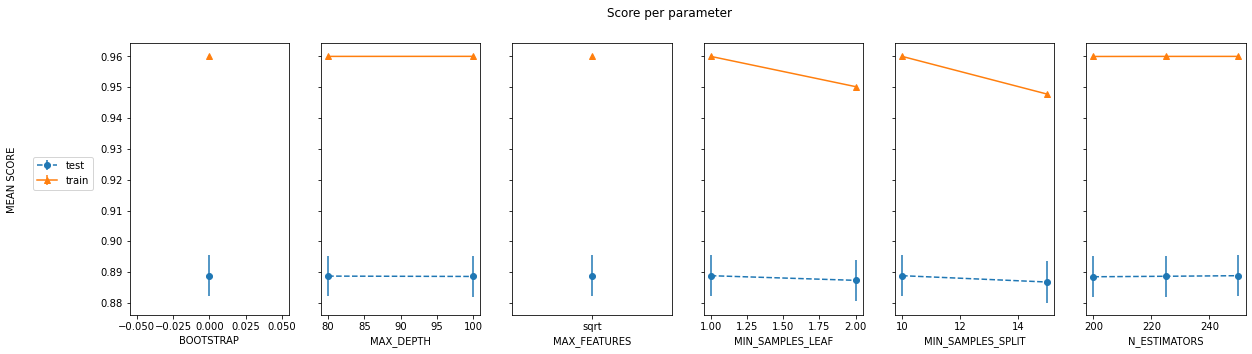

In [101]:
plot_search_results(result_grd, search='GridSearchCV')
plt.savefig('fig/11_grid_search.png')

From the previous plot, we can visualize how was the performance of the model (MEAN SCORE) for each value that each parameter adopted.